In [1]:
# Used for transferring cropped images from Google Drive to Colab workspace
#!unzip "/content/drive/MyDrive/cropped_images.zip" -d "/content/CUB_200_2011/cropped_images"


In [2]:
# Used to print current GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 21:14:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Data import, handling
import pandas as pd

# Data plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Image pre-processing
import matplotlib.image as img

# PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models


# Scikit modules
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from skimage import io, transform

# numpy
import numpy as np

# Standard Library Modules
import time

torch.cuda.empty_cache()
torch.manual_seed(572)

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Credit goes to ptrblack for this class: https://discuss.pytorch.org/t/why-do-we-need-subsets-at-all/49391/7
# This class allows for easier application of different transforms to datasets. Used in the load_split_train_valid_test method
class MyLazyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

# Define helper methods
'''Displays an image alongside its bounding box and part locations. Defaults to not showing hidden parts.
Note that the first piece of data in both box_data and parts_data will be the image id, which is irrelevant for
plotting single images at a time.'''
def display_image(image, box_data, parts_data, show_hidden_parts=False):
    # Create base figure and axis, label plot and axes
    fig, ax = plt.subplots()
    ax.set_title("Bird Image with Bounding Box and Labeled Parts")


    ax.imshow(image)

    # Then create red rectangle representing bounding box
    rect = patches.Rectangle((box_data[1], box_data[2]), box_data[3], box_data[4], ec='r', fc='None')
    ax.add_patch(rect)

    # Then plot each provided part (including hidden parts if specified). Part names must be retrieved from a
    # separate file since the parts_data itself only contains part IDs, not names
    part_names = pd.read_csv("../data/CUB_200_2011/parts/parts.txt", sep="-", index_col=False)

    for inx in range(len(parts_data)):
        part = parts_data.iloc[inx]     # Grab current part
        name = part_names[part_names["part_id"]==part[1]]["part_name"].to_string(index=False)   # Minus one to account for the starting index being 0 for part_names
        x = part[2]
        y = part[3]
        hidden = part[4]
        if(hidden == 1) or show_hidden_parts:    # If the part is visible (or hidden but we want to see it regardless), plot its location
            ax.scatter(x, y)
            ax.annotate(name, xy = (x, y), color="black")
    plt.show()


'''A newly defined collate function to work around a collation error when running batch sizes greater than 1. The original collation
resulted in a RunTimeError caused by trying to resize storage that is not resizable (in other words, the Tensors within each batch had different
shapes, most likely a result of one or more being empty or None). This solution is credited to ptrblack and Sehaba95 on the PyTorch forums.'''
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))        # Convert batch into a collate-able list, filtering out any empty Tensors    
    return torch.utils.data.dataloader.default_collate(batch)   # Pass list to default collate method and return the result


# Note: The default normalize mean and std values are those for the RGB of ImageNet
def load_split_train_test_valid(datadir, test_size=.15, valid_size=.15, normalize_mean=[0.485, 0.456, 0.406], normalize_std=[0.229, 0.224, 0.225]):
    try:
        if(test_size < 0 or valid_size < 0):
            raise ValueError

        percentage_sum = test_size+valid_size
        if(percentage_sum >= 1 or percentage_sum <= 0):
            raise ValueError
    except ValueError:
        print("test_size and valid_size must be non-negative, less than 1, and their sum must be less than 1.")
        exit(1)
    
    # Design each transform composition with bird photography in mind
    train_transforms = transforms.Compose([transforms.Resize((224, 224)),  # Transform for training
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(-50, 50)),
                                        transforms.ColorJitter(hue=(0,0)),   # Disable hue change
                                        transforms.ToTensor(),
                                        transforms.Normalize(normalize_mean, normalize_std)])

    test_valid_transforms = transforms.Compose([transforms.Resize((224, 224)), # Transform for test/validation
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomRotation(degrees=(-50, 50)),
                                        transforms.ColorJitter(hue=(0,0)),   # Disable hue change
                                        transforms.ToTensor(),
                                        transforms.Normalize(normalize_mean, normalize_std)])


    all_data = datasets.ImageFolder(datadir)

    train_data = MyLazyDataset(all_data,transform=train_transforms)
    test_data = MyLazyDataset(all_data,transform=test_valid_transforms)
    valid_data = MyLazyDataset(all_data,transform=test_valid_transforms)

    total_count = len(all_data)
    #test_count = int(test_size*total_count)
    #valid_count = int(valid_size*total_count)
    train_size = 1 - test_size - valid_size

    indices = np.arange(0,total_count)
    first_split = int(np.floor(train_size*total_count))
    second_split = int(np.floor((train_size+(test_size))*total_count))
    np.random.shuffle(indices)  # Shuffle the indices
    train_inx = indices[:first_split]
    test_inx = indices[first_split:second_split]
    valid_inx = indices[second_split:]
    
    train_data = Subset(train_data, indices=train_inx)
    test_data = Subset(test_data, indices=test_inx)
    valid_data = Subset(valid_data, indices=valid_inx)

    # Define parameters for the dataloaders
    batch_size = 128
    num_workers = 2

    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, drop_last=True, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, drop_last=True, collate_fn=collate_fn, pin_memory=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, drop_last=True, collate_fn=collate_fn, pin_memory=True)


    """    train_data, test_data, valid_data = random_split(
                                            all_data, 
                                            (train_count, test_count, valid_count),
                                            generator=torch.Generator().manual_seed(572)) """

    return train_loader, test_loader, valid_loader

In [5]:
################################################################################# Building and Preparing the Pre-trained Model ######################################################################################################################
# Import and process data
data_dir = '/content/CUB_200_2011/cropped_images'

# Build training/test sets randomly, applying the appropriate transformations to each set of images (normalization, cropping, etc.)
train_loader, test_loader, valid_loader = load_split_train_test_valid(data_dir, .1, .3)

In [6]:
# Load the model (implementation of the VGG16 model with batch normalization). Though we could build a CNN from scratch specific to birds, it's
# quicker and requires less bird images to fine tune a pre-existing network.
model = models.vgg16_bn(pretrained=True)

# Use GPU CUDA cores for training if available, else default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Given the data similarity between the ImageNet dataset that the VGG16 model was trained on and our bird dataset,
# we want to preserve most of the model's original parameters when training; in other words, we need to avoid updating the model when backpropagating
# most of the model's layers

In [7]:
for parameter in model.parameters():  # "Freeze" every layer's parameters 
    parameter.requires_grad_(False)

# VGG-16 has a 4096 dimension output layer, which isn't what we need. Instead, we can modify the fully-connected
# layer to fine-tune the network for our purposes. In this case, we want 200 dimensional output (for each category of bird)
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(nn.Linear(num_features, 4096, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(4096, 4096, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=200, bias=True))    # 200 output layers

model.to(device)
# Note: The pre-trained VGG16_bn model lacks a SoftMax layer (as do all pre-trained models from torchvision), and we didn't add one above. 
# However, this isn't an issue as these models are trained using CrossEntropyLoss, which for this purpose are equivalent to the combination of 
# LogSoftMax and NLLLoss (so no need to add it to the model itself)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [8]:
################################################################################# Finalizing the Model and Training ######################################################################################################################
# Define the loss function for the model
criterion = nn.CrossEntropyLoss()   
# Pass the unfrozen parameters to the optimizer (it's needless to backpropagate through every layer when the early ones are frozen; just backpropagate through the unfrozen end layers)
optimizer = optim.SGD(filter(lambda p: p.requires_grad_, model.parameters()), lr=1e-1)
# Decrease learning rate if the global minimum training loss has not decreased in 3 epochs (the optimizer above is alreafy an adaptive learning rate optimizer, but further adaptability will help bring minor improvements)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)   

In [9]:
# Training the model
try:
    #num_epochs = int(input("How many epochs would you like to spend training the model? "))
    num_epochs = 100
    if num_epochs <= 0:
        raise ValueError
except TypeError:
    print("Must be an integer. Using default number of epochs instead (20)")
    num_epochs = 20
except ValueError:
    print("Must be a positive integer. Using default number of epochs instead (20)")
    num_epochs = 20
    
start_time = time.time()        # Start tracking runtime

loss_stats = {    # Store loss over epochs during training and validation
    'train': [],
    "val": []
}

acc_stats = {    # Store accuracy over epochs during training and validation
    'train': [],
    "val": []
}

iters = []       # Track epoch number for plotting

# Track best validation loss and number of previous consecutive epochs with no loss improvements for basic early stopping implementation
best_val_loss = 0
no_improvement_streak = 0
print(iters)

[]


In [10]:
# Create accuracy calculation function before training model
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes==labels).float())

In [11]:
print("Beginning training.")
for epoch_num in range(0, num_epochs):
    train_epoch_loss = 0    # Tracks training loss over the epoch 
    val_epoch_loss = 0      # Tracks validation loss over the epoch
    train_accuracy = 0      # Tracks training accuracy after each epoch
    val_accuracy = 0        # Tracks validation accuracy after each epoch

    if epoch_num == 0:
        best_val_loss = 1000000 # Arbitrary high value
        last_val_loss = None    # Tracks last epoch's validation loss for early stopping purposes


    print(f"Training for Epoch {epoch_num}...")
    for batch_inx, (data, targets) in enumerate(train_loader):
        #print(f"\tBatch {batch_inx} starting...")
        data = data.to(device)   # Utilize CUDA if available
        targets = targets.to(device)

        # Forward pass (calculates predicted output)
        output = model(data)

        # Calculate batch loss
        train_loss = criterion(output, targets)   

        # Backward pass (calculates gradient with respect to model parameters)
        train_loss.backward()         

        # Iterate over all parameters to update their values based on gradient. 
        # Recall that the parameters of most layers have been "frozen" earlier, so their values won't update
        optimizer.step()   

        # Explicitly set gradients to zero before next backwards pass (no need to keep the gradient accumulated)
        optimizer.zero_grad(set_to_none=True)

        # Combine current training loss to epoch losses
        train_epoch_loss += train_loss.item()

        # Calculate accuracy
        train_accuracy += accuracy(output, targets)

        #if batch_inx != 0 and batch_inx %5 == 0: break
    
    # Calculate overall training loss/acc for the epoch
    mean_train_loss = train_epoch_loss/len(train_loader)
    train_accuracy /= len(train_loader)

    # Update learning rate scheduler before next batch
    scheduler.step(mean_train_loss)   # See if the learning rate needs to adapt
    print(f"Epoch {epoch_num} finished training; moving on to validation...")

    # Validation
    with torch.no_grad():
        model.eval()

        for batch_inx, (data, targets) in enumerate(valid_loader):
            #print(f"\tBatch {batch_inx} starting...")
            data = data.to(device)
            targets = targets.to(device)

            output = model(data)    # Obtain classification guess from model

            # Calculate validation loss
            val_epoch_loss = criterion(output, targets).item()

            # Calculate validation accuracy
            val_accuracy += accuracy(output, targets)

            #if batch_inx != 0 and batch_inx %5 == 0: break

    # Calculate validation loss and accuracy, set the last validation loss
    mean_val_loss = val_epoch_loss/len(valid_loader)
    val_accuracy /= len(valid_loader)

    # Append loss and accuracy stats to respective dictionaries before next epoch
    loss_stats['train'].append(mean_train_loss)
    loss_stats['val'].append(mean_val_loss)
    acc_stats['train'].append(100*train_accuracy.item())  # Multiply by 100 for percentage
    acc_stats['val'].append(100*val_accuracy.item())

    # Track current epoch
    iters.append(epoch_num)

    # Display current epoch, training loss, and validation loss 
    print(f'Validation complete. Epoch {epoch_num+0:03}: | Train Loss: {mean_train_loss:.5f} | Val Loss: {mean_val_loss:.5f}')

    # Compare best validation loss to current before moving on to next epoch; if the validation loss is better, update best validation loss and save the current model
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss

        # Save snapshot of model and scheduler to file
        save_model_path = "/content/model/vgg16_bird100.pth"
        torch.save(model.state_dict(), save_model_path)
        save_scheduler_path = "/content/model/vgg16_bird_scheduler100"
        torch.save(scheduler.state_dict(), save_scheduler_path)


    
    # If this epoch's validation loss is worse or equal to the last epoch's, increment the streak
    if last_val_loss is not None and mean_val_loss >= last_val_loss:
        no_improvement_streak += 1
    else:
        # If the validation loss improves, then reset the streak
        no_improvement_streak = 0
    
    # If the validation loss was worse during the last 5 epochs and still did not improve, stop the training early to avoid overfitting
    if no_improvement_streak >= 6:
        print("Overfitting detected, commencing early stopping of the training...")
        break

    # Update last val loss before next epoch
    last_val_loss = mean_val_loss

print("--- %s seconds ---" % (time.time() - start_time))    # Print total duration of training/validation

Beginning training.
Training for Epoch 0...
Epoch 0 finished training; moving on to validation...
Validation complete. Epoch 000: | Train Loss: 5.28706 | Val Loss: 0.19475
Training for Epoch 1...
Epoch 1 finished training; moving on to validation...
Validation complete. Epoch 001: | Train Loss: 5.17291 | Val Loss: 0.18710
Training for Epoch 2...
Epoch 2 finished training; moving on to validation...
Validation complete. Epoch 002: | Train Loss: 4.64238 | Val Loss: 0.15746
Training for Epoch 3...
Epoch 3 finished training; moving on to validation...
Validation complete. Epoch 003: | Train Loss: 3.70681 | Val Loss: 0.12943
Training for Epoch 4...
Epoch 4 finished training; moving on to validation...
Validation complete. Epoch 004: | Train Loss: 2.96660 | Val Loss: 0.10639
Training for Epoch 5...
Epoch 5 finished training; moving on to validation...
Validation complete. Epoch 005: | Train Loss: 2.44360 | Val Loss: 0.09496
Training for Epoch 6...
Epoch 6 finished training; moving on to vali


Model complete, plotting statistics...
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[5.2870555530894885, 5.172905349731446, 4.642377610640092, 3.706808497688987, 2.966603929346258, 2.4436015996066005, 2.103301910920577, 1.8194598718123003, 1.6186430150812323, 1.4609413753856313, 1.3307074525139548, 1.1958961335095493, 1.083111035823822, 1.0084207350557501, 0.9214613155885176, 0.8624656124548479, 0.8064664255489002, 0.7321194627068259, 0.6892535480585965, 0.6484363675117493, 0.6084269019690427, 0.5579126926985654, 0.5180466185916554, 0.5006401099941947, 0.4487476646900177, 0.4400708328593861, 0.40619916753335433, 0.3757059156894684, 0.35125015161

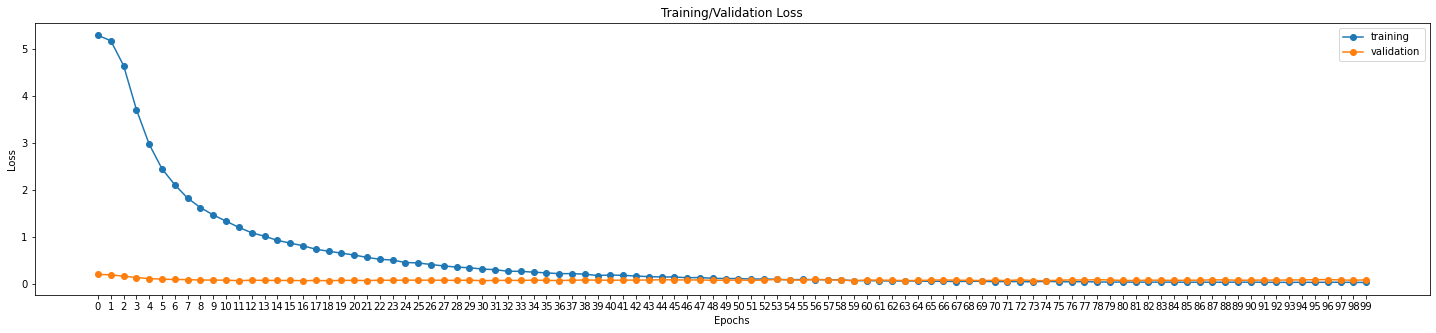


[0.8664772845804691, 3.749999776482582, 8.096590638160706, 15.213067829608917, 26.491475105285645, 36.50568127632141, 43.83522570133209, 50.497156381607056, 55.32670021057129, 59.17613506317139, 62.31533885002136, 65.93749523162842, 69.14772391319275, 71.69033885002136, 74.34659004211426, 75.12784004211426, 77.21590399742126, 79.7443151473999, 80.14204502105713, 81.42045140266418, 82.61363506317139, 84.81533527374268, 85.22726893424988, 85.88067889213562, 87.41477131843567, 87.54261136054993, 88.49431276321411, 89.31818008422852, 90.2130663394928, 90.625, 91.12215638160706, 91.88920259475708, 93.13920140266418, 93.55113506317139, 93.62215399742126, 94.09090876579285, 94.47442889213562, 94.30397152900696, 94.50283646583557, 95.66761255264282, 95.15624642372131, 95.44034004211426, 95.95170021057129, 96.4630663394928, 96.67613506317139, 96.54829502105713, 97.05965518951416, 96.8323826789856, 97.51420021057129, 97.81249761581421, 97.37215638160706, 97.86931276321411, 97.57102131843567, 97

<Figure size 432x288 with 0 Axes>

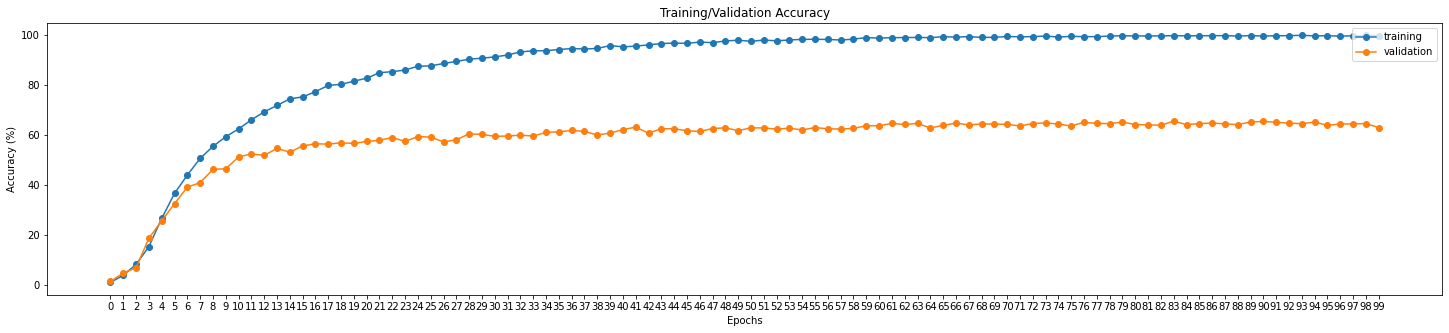


Final losses: Train - 0.024482943066819148 | Val - 0.08008274325618038
Final accuracies: Train - 99.6874988079071 | Val - 62.84722089767456


In [15]:
print('\nModel complete, plotting statistics...')
# Visualize Training/Validation Loss and Accuracy
print(iters)
print(loss_stats['train'])
print(loss_stats['val'])
plt.figure(figsize=(25,5))
plt.plot(iters, loss_stats['train'], label='training', marker='o')
plt.plot(iters, loss_stats['val'], label='validation', marker='o')
plt.title("Training/Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.xticks(range(0,len(iters)))
plt.show()

plt.clf()   # Clear figure
print()
print(acc_stats["train"])
print(acc_stats["val"])
plt.figure(figsize=(25,5))
plt.plot(iters, acc_stats['train'], label='training', marker='o')
plt.plot(iters, acc_stats['val'], label='validation', marker='o')
plt.title("Training/Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")
plt.xticks(range(0,len(iters)))
plt.show()
print()
print(f"Final losses: Train - {loss_stats['train'][-1]} | Val - {loss_stats['val'][-1]}")
print(f"Final accuracies: Train - {acc_stats['train'][-1]} | Val - {acc_stats['val'][-1]}")
plt.close()

In [13]:
# Test Accuracy
def test_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        model.eval()

        for batch_inx, (data, targets) in enumerate(loader):
            #print(f"\tBatch {batch_inx} starting...")
            data = data.to(device)
            targets = targets.to(device)

            output = model(data)    # Obtain classification guess from model

            # Calculate  accuracy
            num_correct += accuracy(output, targets)

    return float(num_correct)/float(len(loader))

In [14]:
print(f"Test Accuracy for VGG-16 model with {num_epochs} epochs: {100*test_accuracy(test_loader, model)}%")

Test Accuracy for VGG-16 model with 100 epochs: 64.93055555555556%
